# BERT 분류기 학습


> 솔트룩스 AI Labs NLP 파트 김성현 주임 (bananaband657@gmail.com)



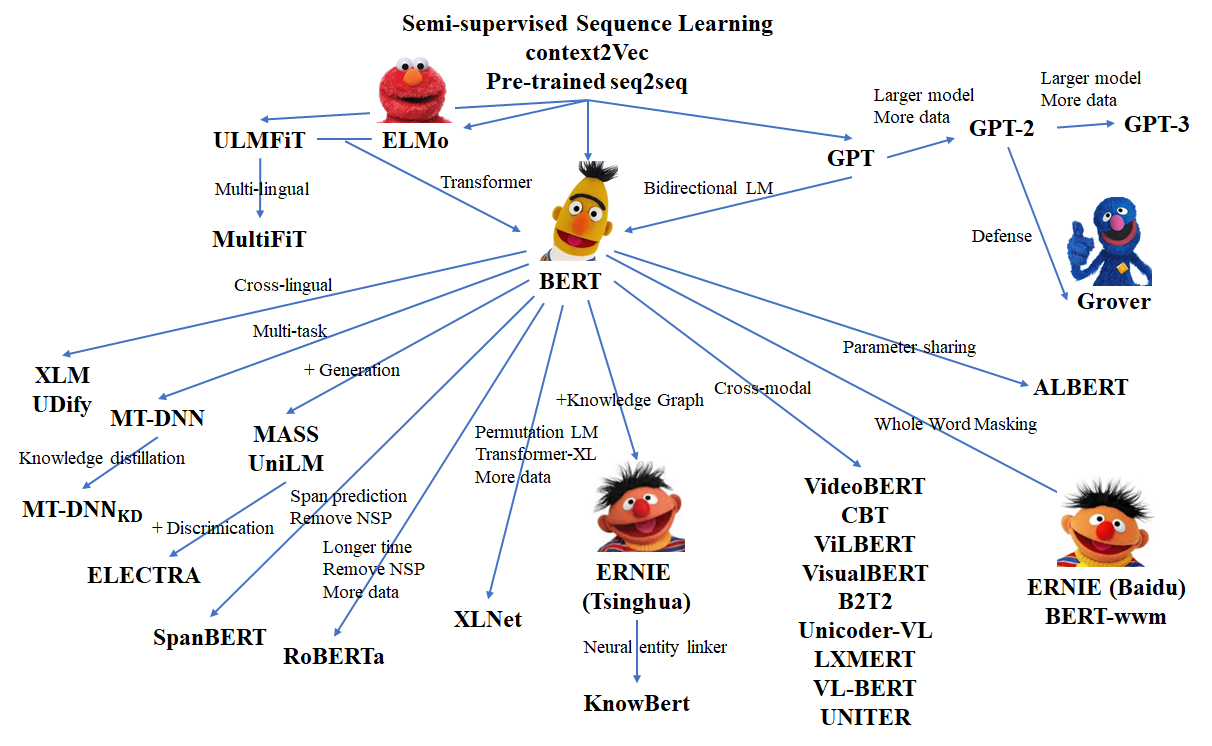

* 현재 솔트룩스에는 다음과 같은 BERT 모델이 구축되어 있습니다.
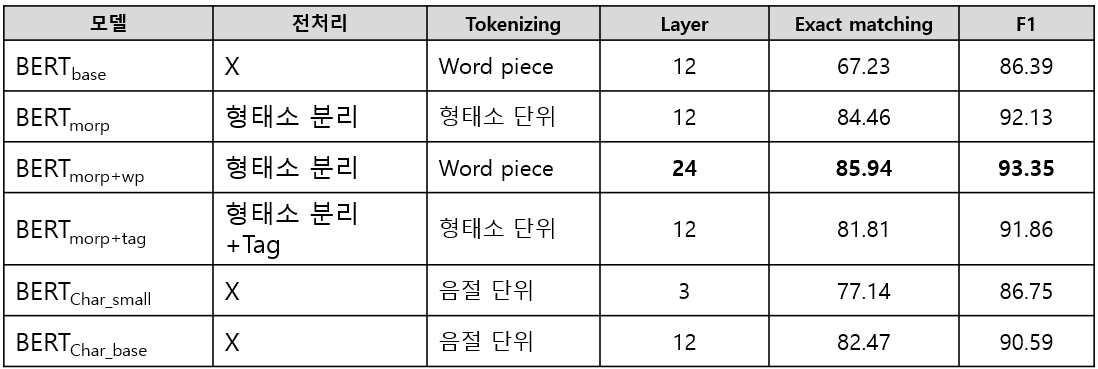

### 실습 over view

본 실습을 통해 목표로 하는 NLP Task는 다음과 같습니다.

*   감성 분류기
*   문장 유사도 분류기







* BERT는 임베딩 벡터를 출력하는 모델이라고만 생각하겠습니다.   
즉, Word2Vec이나 FastText, Sent2vec 처럼 입력된 문장에 대해서 vector를 출력하는 모델입니다.   
* 단, BERT는 입력된 모든 token에 대한 벡터를 출력합니다.
* 분류의 대상이 되는 sentence embedding vector 를 얻기 위해, [CLS] token을 입력 문장의 맨 앞에 넣어줍니다.

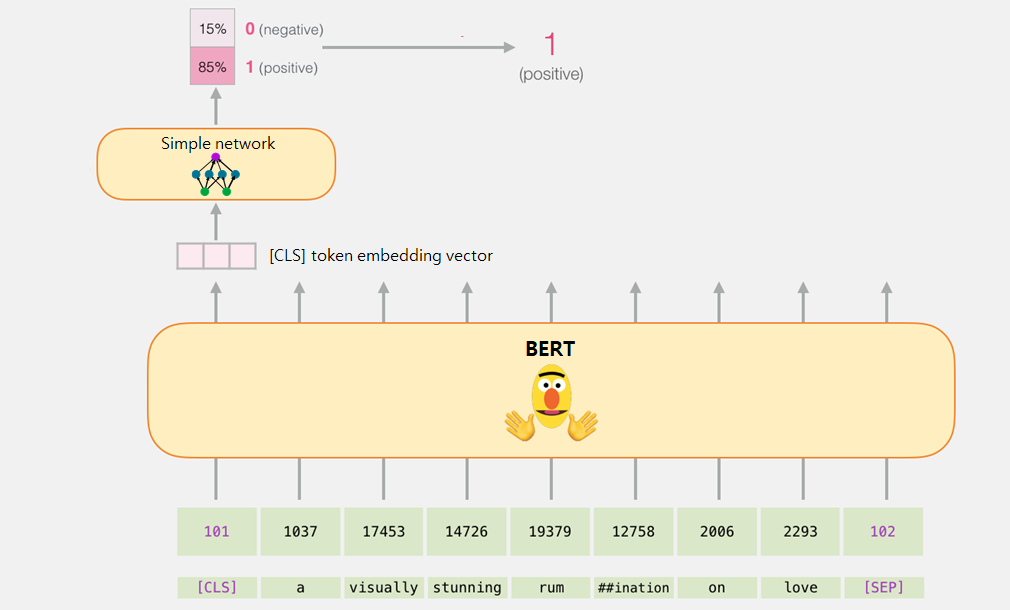

### 한국어 BERT 모델 및 공식 코드 가져오기

* 이번 실습을 통해 사용할 BERT 모델은 한국어 위키 문서를 이용해 200,000 step을 학습한 한국어 BERT 샘플 모델입니다.

In [1]:
!git clone https://github.com/google-research/bert.git

Cloning into 'bert'...
remote: Enumerating objects: 340, done.
remote: Total 340 (delta 0), reused 0 (delta 0), pack-reused 340
Receiving objects: 100% (340/340), 317.85 KiB | 1010.00 KiB/s, done.
Resolving deltas: 100% (185/185), done.


In [2]:
!curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=1UmM0ov96dk3YWxuDIImcnetBM-9Kn8q3" > /dev/null
!curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=`awk '/download/ {print $NF}' ./cookie`&id=1UmM0ov96dk3YWxuDIImcnetBM-9Kn8q3" -o pretrained_model.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   2305      0 --:--:-- --:--:-- --:--:--  2305
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1310M    0 1310M    0     0  68.6M      0 --:--:--  0:00:19 --:--:-- 69.7M


In [3]:
!mkdir pretrained_model
!unzip pretrained_model.zip -d pretrained_model

Archive:  pretrained_model.zip
   creating: pretrained_model/conf/
  inflating: pretrained_model/conf/bert_config.json  
  inflating: pretrained_model/conf/vocab.txt  
  inflating: pretrained_model/model_output_512_eval_results.docx  
  inflating: pretrained_model/model_output_512_graph.pbtxt  
  inflating: pretrained_model/model_output_512_model.ckpt-200000.data-00000-of-00001  
  inflating: pretrained_model/model_output_512_model.ckpt-200000.index  
  inflating: pretrained_model/model_output_512_model.ckpt-200000.meta  


In [4]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


### BERT tokenizing 테스트

In [6]:
import bert.tokenization as tokenization

tokenizer = tokenization.FullTokenizer(
        vocab_file='pretrained_model/conf/vocab.txt',
        do_lower_case=False)

line = '이순신은 조선 중기의 무신이다.'
print(tokenizer.tokenize(line))

['이순신', '##은', '조선', '중기', '##의', '무', '##신', '##이다', '.']


### 감성 분류기 학습

* 먼저 감성 분류 학습 데이터를 다운받도록 하겠습니다.

In [7]:
!git clone https://github.com/e9t/nsmc.git

Cloning into 'nsmc'...
remote: Enumerating objects: 14763, done.
remote: Total 14763 (delta 0), reused 0 (delta 0), pack-reused 14763
Receiving objects: 100% (14763/14763), 56.19 MiB | 9.20 MiB/s, done.
Resolving deltas: 100% (1749/1749), done.
Checking out files: 100% (14737/14737), done.


In [ ]:
!mv /content/nsmc/ratings_train.txt /content/nsmc/train.tsv
!mv /content/nsmc/ratings_test.txt /content/nsmc/dev.tsv

In [ ]:
!head -n 10 /content/nsmc/train.tsv
!cat /content/nsmc/train.tsv | wc -l

id	document	label
9976970	아 더빙.. 진짜 짜증나네요 목소리	0
3819312	흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나	1
10265843	너무재밓었다그래서보는것을추천한다	0
9045019	교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정	0
6483659	사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다	1
5403919	막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.	0
7797314	원작의 긴장감을 제대로 살려내지못했다.	0
9443947	별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단 낫겟다 납치.감금만반복반복..이드라마는 가족도없다 연기못하는사람만모엿네	0
7156791	액션이 없는데도 재미 있는 몇안되는 영화	1
150001


* BERT 모델에는 감성 분류를 위한 문장A와 label이 쌍이 되어 학습데이터로 사용될 것입니다.
* 따라서 위의 문장을 `['[CLS]', '문장A', '[SEP]']` 형태로 만들어 주도록 하겠습니다.

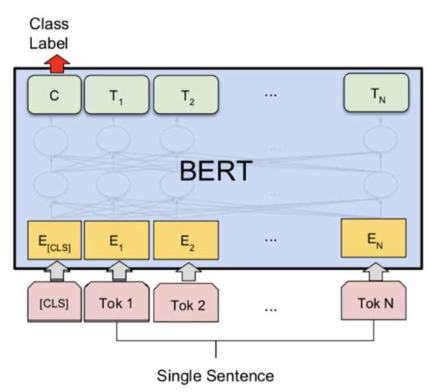


* 위 데이터를 학습하기 위해서 기존 BERT 코드 중, run_classifier.py를 사용하겠습니다.   
* 해당 코드의 336 line `ColaProcessor`를 이용하면 입력되는 한 문장에 대한 이진분류가 가능합니다. 
 

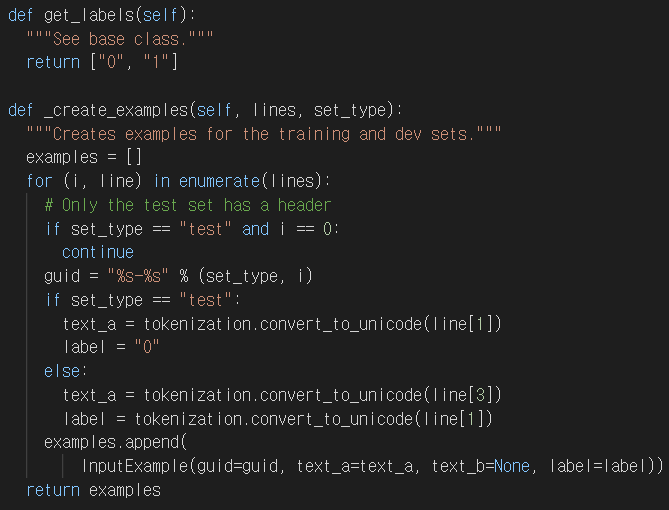

* 앞으로 우리가 관심있는 부분은 `get_labels()`와 `_create_example(`) 뿐입니다.   
* 분류하고자 하는 label의 종류에 따라 `get_labels()`의 return에 위치한 배열에 label을 추가해주면 됩니다.
* 예를 들어, nsmc 데이터의 경우, label이 0과 1로 되어 있기 때문에, 변화를 줄 필요가 없습니다.
* 만약 자신의 데이터가 normal, positive, negative로 분류되어 있다면,    
`["normal", "positive", "negative"]` 로 수정해주시면 됩니다.   

* `_create_example()` 함수에서 학습데이터를 읽고, tokenization을 통해 학습 가능한 형식으로 변환시켜 줍니다.   
* 여기서는 `text_a`가 한 개의 문장이 됩니다.
* 4번째 데이터가 문장이고, 2번째 데이터를 label로 보고 있습니다.
* 따라서 해당 코드를 아래와 같이 수정하도록 하겠습니다.
* 또한, 전체 학습을 하기엔 시간이 오래 걸리니, 2,000문장만 학습하도록 하겠습니다. 


In [ ]:
  def _create_examples(self, lines, set_type):
    """Creates examples for the training and dev sets."""
    examples = []
    for (i, line) in enumerate(lines):
      # nsmc data contains head
      if i == 0:
        continue
      if i > 2000:
        break
      guid = "%s-%s" % (set_type, i)
      if set_type == "test":
        text_a = tokenization.convert_to_unicode(line[1])
        label = "0"
      else:
        text_a = tokenization.convert_to_unicode(line[1])
        label = tokenization.convert_to_unicode(line[2])
      examples.append(
          InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
    return examples

* 수정이 완료되었다면, 감성 분류기 모델을 학습해보겠습니다.

In [ ]:
!python /content/bert/run_classifier.py \
--task_name=cola \
--do_train=true \
--do_eval=true \
--data_dir=/content/nsmc \
--vocab_file=/content/pretrained_model/conf/vocab.txt \
--bert_config_file=/content/pretrained_model/conf/bert_config.json \
--init_checkpoint=/content/pretrained_model/model_output_512_model.ckpt-200000 \
--max_seq_length=128 \
--train_batch_size=32 \
--num_train_epochs=1.0 \
--learning_rate=2e-5 \
--do_lower_case=false \
--output_dir=/content/nsmc_output




W0714 01:34:16.069405 139637606709120 module_wrapper.py:139] From /content/bert/run_classifier.py:786: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.


W0714 01:34:16.069634 139637606709120 module_wrapper.py:139] From /content/bert/run_classifier.py:786: The name tf.logging.INFO is deprecated. Please use tf.compat.v1.logging.INFO instead.


W0714 01:34:16.070111 139637606709120 module_wrapper.py:139] From /content/bert/modeling.py:93: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0714 01:34:16.070800 139637606709120 module_wrapper.py:139] From /content/bert/run_classifier.py:810: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  

* 모델 학습이 완료되었으며, dev dataset으로 평가한 결과를 얻을 수 있습니다. (eval_accuracy = 0.7915)
* 전체 데이터로 학습할 경우, 약 86점 정도의 정확도를 얻을 수 있습니다.   

### 감성 분류기 테스트

* nsmc_output에 학습된 모델에 대한 정보가 저장되어 있습니다.   
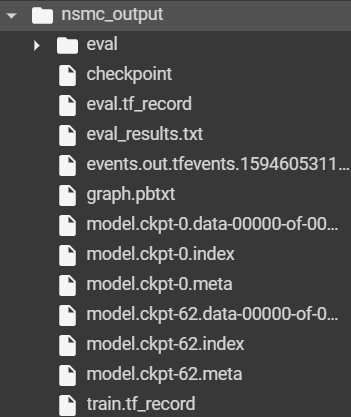

* 이 모델을 이용해 감성분류를 테스트하는 코드를 작성해보겠습니다.
* 아래 코드를 시작하기 전에, 런타임 다시 시작을 꼭 해주세요.

In [ ]:
%tensorflow_version 1.x

import bert.modeling as modeling
import bert.tokenization as tokenization
import tensorflow as tf
import json
import collections
import time
import sys
import numpy as np  

TensorFlow 1.x selected.


In [ ]:
label_list = ['0', '1']

In [ ]:
class InputFeatures(object):
      def __init__(self,
               input_ids,
               input_mask,
               segment_ids,
               label_id,
               is_real_example=True):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id
        self.is_real_example = is_real_example

In [ ]:
class InputExample(object):
    def __init__(self, guid, text, label=None):
        self.guid = guid
        self.text = text
        self.label = label

In [ ]:
class PaddingInputExample(object):
      """Fake example so the num input examples is a multiple of the batch size.

  When running eval/predict on the TPU, we need to pad the number of examples
  to be a multiple of the batch size, because the TPU requires a fixed batch
  size. The alternative is to drop the last batch, which is bad because it means
  the entire output data won't be generated.

  We use this class instead of `None` because treating `None` as padding
  battches could cause silent errors.
  """

In [ ]:
def get_kor_examples(sent):
    examples = []
    ori_sents = []
    sent = sent.strip()
    sent = sent.split('\n')
    for sent__ in sent:
        #for sent_ in sent_tokenize(sent__):
        ori_sents.append(sent__)
        tokens = tokenizer.tokenize(sent__)
        guid = "%s-%s" % ('test', 0)
        examples.append(InputExample(guid=guid, text=tokens, label='0'))
    return examples, ori_sents

In [ ]:
def convert_single_example(ex_index, example, label_list, max_seq_length,
                           tokenizer):
  """Converts a single `InputExample` into a single `InputFeatures`."""

  if isinstance(example, PaddingInputExample):
    return InputFeatures(
        input_ids=[0] * max_seq_length,
        input_mask=[0] * max_seq_length,
        segment_ids=[0] * max_seq_length,
        label_id=0,
        is_real_example=False)

  label_map = {}
  for (i, label) in enumerate(label_list):
    label_map[label] = i
  # print('example', example.text)
  # tokens_a = tokenizer.tokenize(example.text)
  tokens_a = example.text
  tokens_b = None
  
  if len(tokens_a) > max_seq_length - 2:
    tokens_a = tokens_a[0:(max_seq_length - 2)]

  # The convention in BERT is:
  # (a) For sequence pairs:
  #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
  #  type_ids: 0     0  0    0    0     0       0 0     1  1  1  1   1 1
  # (b) For single sequences:
  #  tokens:   [CLS] the dog is hairy . [SEP]
  #  type_ids: 0     0   0   0  0     0 0
  #
  # Where "type_ids" are used to indicate whether this is the first
  # sequence or the second sequence. The embedding vectors for `type=0` and
  # `type=1` were learned during pre-training and are added to the wordpiece
  # embedding vector (and position vector). This is not *strictly* necessary
  # since the [SEP] token unambiguously separates the sequences, but it makes
  # it easier for the model to learn the concept of sequences.
  #
  # For classification tasks, the first vector (corresponding to [CLS]) is
  # used as the "sentence vector". Note that this only makes sense because
  # the entire model is fine-tuned.
  tokens = []
  segment_ids = []
  tokens.append("[CLS]")
  segment_ids.append(0)
  for token in tokens_a:
    tokens.append(token)
    segment_ids.append(0)
  tokens.append("[SEP]")
  segment_ids.append(0)


  input_ids = tokenizer.convert_tokens_to_ids(tokens)

  # The mask has 1 for real tokens and 0 for padding tokens. Only real
  # tokens are attended to.
  input_mask = [1] * len(input_ids)

  # Zero-pad up to the sequence length.
  while len(input_ids) < max_seq_length:
    input_ids.append(0)
    input_mask.append(0)
    segment_ids.append(0)

  assert len(input_ids) == max_seq_length
  assert len(input_mask) == max_seq_length
  assert len(segment_ids) == max_seq_length

  label_id = label_map[example.label]

  feature = InputFeatures(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids,
      label_id=label_id,
      is_real_example=True)
  return feature

In [ ]:
def convert_examples_to_features(examples, label_list, max_seq_length,
                                 tokenizer):
  """Convert a set of `InputExample`s to a list of `InputFeatures`."""

  features = []
  for (ex_index, example) in enumerate(examples):
    feature = convert_single_example(ex_index, example, label_list,
                                     max_seq_length, tokenizer)
    features.append(feature)
  return features

In [ ]:
def graph_model(bert_config, is_training, input_ids, input_mask,
                 segment_ids, labels, num_labels, use_one_hot_embeddings):

    model = modeling.BertModel(
        config=bert_config,
        is_training=is_training,
        input_ids=input_ids,
        input_mask=input_mask,
        token_type_ids=segment_ids,
        use_one_hot_embeddings=use_one_hot_embeddings
    )

    output_layer = model.get_pooled_output()

    hidden_size = output_layer.shape[-1].value

    output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

    output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    probabilities = tf.nn.softmax(logits, axis=-1)
    log_probs = tf.nn.log_softmax(logits, axis=-1)
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    probabilities = tf.nn.softmax(logits, axis=-1)
    predict = tf.argmax(probabilities,axis=-1)
    return predict

In [ ]:
def get_feed_dict(features):
    input_ids_list = []
    input_mask_list = []
    segment_ids_list = []
    for feature in features:
        input_ids_list.append(feature.input_ids)
        input_mask_list.append(feature.input_mask)
        segment_ids_list.append(feature.segment_ids)
    return {input_ids: input_ids_list, input_mask:input_mask_list, segment_ids:segment_ids_list}

In [ ]:
bert_config = modeling.BertConfig.from_json_file("pretrained_model/conf/bert_config.json")
tokenizer = tokenization.FullTokenizer(vocab_file="pretrained_model/conf/vocab.txt", do_lower_case=False)

label_ids = tf.placeholder(shape=[None,None], dtype=tf.int32)
input_ids = tf.placeholder(shape=[None,None], dtype=tf.int32)
input_mask = tf.placeholder(shape=[None,None], dtype=tf.int32)
segment_ids = tf.placeholder(shape=[None,None], dtype=tf.int32)
use_one_hot_embeddings=False

num_labels = 2

predict_ = graph_model(
            bert_config, False, input_ids, input_mask, segment_ids, label_ids, num_labels, use_one_hot_embeddings)
print('\tmodel is initialized!')
tf_config = tf.ConfigProto()

sess = tf.Session(config = tf_config)
sess.run(tf.global_variables_initializer())
model_loader = tf.train.Saver()
model_loader.restore(sess, "nsmc_output/model.ckpt-62")
print('\tmodel is set!')





The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
	model is initialized!
INFO:tensorflow:Restoring parameters from nsmc_output/model.ckpt-62
	model is set!


In [ ]:
def get_senti(sentence):
    eval_examples, ori_sents = get_kor_examples(sentence)
    eval_features = convert_examples_to_features(
            examples=eval_examples,
            label_list=label_list,
            tokenizer=tokenizer,
            max_seq_length=512,
    )

    predicts = sess.run(predict_, feed_dict=get_feed_dict(eval_features))
    return predicts[0]

In [ ]:
print(get_senti('힘들어서 그냥 퇴근하고 싶어 죽겠다.'))
print(get_senti('지금 기분이 너무 행복해.'))
print(get_senti('답답하고 짜증나 죽겠어.'))

0
1
0


### 문장 유사도 학습

* 문장 유사도는 주어진 두 문장이 서로 유사함 여부를 학습하게 됩니다.
* 먼저 데이터를 다운받도록 하겠습니다.

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
!git clone https://github.com/songys/Question_pair

Cloning into 'Question_pair'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 99 (delta 23), reused 12 (delta 3), pack-reused 54
Unpacking objects: 100% (99/99), done.


In [ ]:
!mv Question_pair/train.txt Question_pair/train.tsv
!mv Question_pair/test.txt Question_pair/dev.tsv

In [ ]:
!head -n 20 Question_pair/train.tsv

question1	question2	is_duplicate
여자친구가 데이트 시간을 너무 안 지켜.	여자친구가 데이트 시간을 너무 안 지켜.	0
집앞에서 첫사랑 만남	집앞에서 첫사랑 만남	0
어이가 없네	어이상실	0
전화 안 받으니까 초조해져	전화 안 받는 이유가 뭘까	0
연인인데 정치견해가 달라	연인인데 정치적인 견해가 달라	0
이 좀 여유롭게 살고 싶다	여유롭게 살고 싶어	0
냄새날 것 같아 걱정이야	냄새나면 어쩌지	0
혼자 있는 시간이 정말 힘드네	혼자가 되고	1
자연이 넘 예뻐	폭우가 쏟아져서 비 맛았어	1
선풍기 틀어도 더워	선풍기만으로 안 되는 더위	0
어장인건가	어장인건가	0
남자친구가 좋은데 신뢰가 안 생겨.	남자친구가 좋은데 믿지 못하겠어.	0
어느새 헤어진지 한달	어떤 날도, 어떤 말도	1
아부쟁이가 부러워	아부 잘 하는 사람 부럽기도 해	0
짝사랑은 짝사랑으로 남는게 좋은 걸까요.	짝사랑은 짝사랑으로 남는게 좋은 걸까요.	0
새벽에 카톡이 왔네.	생각을 고쳐 먹었습니다	1
다시 썸 타는 방법	덜 좋아하는게 답인 것 같아.	1
제정신이 아닌거 같아	조금씩 아물어가는건가 이별의 상처	1
짝사랑은 힘든 거 같아	짝사랑은 힘든 거 같아	0


In [ ]:
cat Question_pair/train.tsv | wc -l

6137


* 주어진 두 문장이 같은 의미이면 0, 다른 의미이면 1로 테그가 되어 있습니다.
* 두 문장의 유사 여부를 학습시키기 위해서는 BERT 모델에 '두 문장'이 입력으로 들어가야 합니다.
* 즉, `[[CLS], 문장A, [SEP], 문장B, [SEP]]` 형태로 데이터를 입력할 수 있습니다.

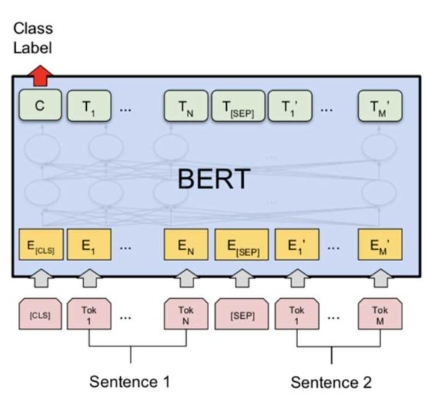


* 마찬가지로 BERT의 run_classifier.py를 이용해 학습해보도록 하겠습니다.
* 이번에는 같은 코드의 296 lines의 `MrpcProcessor`를 사용해서 학습해보겠습니다.
* 앞선 실습과 마찬가지로, 학습 데이터의 순서에 맞춰서 다음과 같이 고쳐주세요.
* 역시 학습 시간이 좀 걸리니, 2,000 문장만 학습하도록 하겠습니다.

In [ ]:
  def _create_examples(self, lines, set_type):
    """Creates examples for the training and dev sets."""
    examples = []
    for (i, line) in enumerate(lines):
      if i == 0:
        continue
      if i > 2000:
        break 
      guid = "%s-%s" % (set_type, i)
      text_a = tokenization.convert_to_unicode(line[0])
      text_b = tokenization.convert_to_unicode(line[1])
      if set_type == "test":
        label = "0"
      else:
        label = tokenization.convert_to_unicode(line[2])
      examples.append(
          InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label))
    return examples

In [ ]:
!python /content/bert/run_classifier.py \
--task_name=mrpc \
--do_train=true \
--do_eval=true \
--data_dir=/content/Question_pair \
--vocab_file=/content/pretrained_model/conf/vocab.txt \
--bert_config_file=/content/pretrained_model/conf/bert_config.json \
--init_checkpoint=/content/pretrained_model/model_output_512_model.ckpt-200000 \
--max_seq_length=128 \
--train_batch_size=32 \
--num_train_epochs=1.0 \
--learning_rate=2e-5 \
--do_lower_case=false \
--output_dir=/content/qp_output




W0714 01:59:08.522954 139876361987968 module_wrapper.py:139] From /content/bert/run_classifier.py:788: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.


W0714 01:59:08.523194 139876361987968 module_wrapper.py:139] From /content/bert/run_classifier.py:788: The name tf.logging.INFO is deprecated. Please use tf.compat.v1.logging.INFO instead.


W0714 01:59:08.523734 139876361987968 module_wrapper.py:139] From /content/bert/modeling.py:93: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0714 01:59:08.524585 139876361987968 module_wrapper.py:139] From /content/bert/run_classifier.py:812: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  

* 결과로 정확도 92%가 나왔습니다. (eval_accuracy = 0.9248021)
* 테스트는 감성분류와 동일하니 생략하겠습니다.